In [79]:
import os
import random
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa

from utils import call_backs, misc, preprocessing
from custom_layers.arcface_loss import ArcMarginProduct

### Config

In [23]:
class config:
    # GENERAL
    RANDOM_SEED = 5
    TENSOR_LOG_DIR = 'logs'
    SAVE_DIR = 'saved_models'

    # DATA
    INPUT_SIZE = (28,28,1)
    NUM_CLASSES = 10

    # MODEL
    OUTPUT_EMB = 64
    MIDDLE_EMB = 256

    # TRAINING
    BATCH_SIZE = 32
    LR = .00001

misc.seed_everything(config.RANDOM_SEED)

### Load dataset

In [24]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = tf.expand_dims(tf.convert_to_tensor(x_train),-1)
y_train = tf.expand_dims(tf.convert_to_tensor(y_train),-1)

In [92]:
y_train.shape

TensorShape([60000, 1])

In [106]:
class_count = Counter(np.array(tf.reshape(y_train, [60000,])))
print(class_count)

Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})


In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(preprocessing.normalize).map(preprocessing.arcface_format).batch(config.BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).map(preprocessing.normalize).map(preprocessing.arcface_format).batch(config.BATCH_SIZE)

### Define model 

In [26]:
# allows 2 inputs and 2 outputs

def get_debug_model(s = 10, m = .25):
 #------------------
    # Definition of placeholders
    inp = tf.keras.layers.Input(shape = config.INPUT_SIZE, name = 'inp1')
    label = tf.keras.layers.Input(shape = (), name = 'inp2')

    # Definition of layers
    
    layer_conv1 = tf.keras.layers.Conv2D(filters = 10, kernel_size = (2,2), input_shape = config.INPUT_SIZE, activation ='relu')
    layer_pool1 = tf.keras.layers.MaxPool2D((2,2))
    layer_conv2 = tf.keras.layers.Conv2D(filters = 12, kernel_size = (2,2), activation ='relu')
    layer_pool2 = tf.keras.layers.MaxPool2D((2,2))
    layer_flatten = tf.keras.layers.Flatten()
    layer_dense1 = tf.keras.layers.Dense(config.MIDDLE_EMB)
    layer_dense2 = tf.keras.layers.Dense(config.NUM_CLASSES)
    layer_subcenter_arcface = ArcMarginProduct(n_classes = config.NUM_CLASSES,s=s, m=m)
    layer_softmax = tf.keras.layers.Softmax(dtype='float16', name='head_output')

    if config.MIDDLE_EMB != config.OUTPUT_EMB:
        layer_adaptive_pooling = tfa.layers.AdaptiveAveragePooling1D(config.OUTPUT_EMB)
    else:
        layer_adaptive_pooling = tf.keras.layers.Lambda(lambda x: x)  # layer with no operation

    #------------------
    # Definition of entire model      --- w/o arcface accuracy is ~.87, try to get at least close to that
    backbone_output = layer_conv1(inp)
    backbone_output = layer_pool1(backbone_output)
    backbone_output = layer_conv2(backbone_output)
    backbone_output = layer_pool2(backbone_output)
    embed = layer_flatten(backbone_output)
    embed = layer_dense1(embed)
    
    # Training head
    head_output = layer_dense2(embed)
    head_output = layer_softmax(head_output)
    
    # Inference
    emb_output = layer_adaptive_pooling(embed)

    model = tf.keras.models.Model(inputs = [(inp, label)], outputs = [head_output, emb_output]) # whole architecture

    return model

In [27]:
debug_model = get_debug_model(s=32, m = .15)
debug_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 27, 27, 10)   50          ['inp1[0][0]']                   
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 13, 13, 10)  0           ['conv2d_2[0][0]']               
                                                                                                  
 conv2d_3 (Conv2D)              (None, 12, 12, 12)   492         ['max_pooling2d_2[0][0]']        
                                                                                            

In [28]:
debug_model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = config.LR),
        loss = {'head_output':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)},
        metrics = {'head_output':[tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3)]},
        )

steps_per_epoch = len(train_dataset) // config.BATCH_SIZE  // 20     # "//20" means that the lr is update every 0.1 epoch.
validation_steps = len(test_dataset) // config.BATCH_SIZE
if len(test_dataset) % config.BATCH_SIZE != 0:
    validation_steps += 1
print(steps_per_epoch, validation_steps)

2 10


### Callbacks

In [29]:
# tensorboard

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                        #  write_graph=True,
                        #  write_images=True,
                        update_freq='epoch',
                        #  profile_batch=2,
                        #  embeddings_freq=1
                        )

#emb_callback = call_backs.EmbeddingCallback(x_test, y_test, save_dir = log_dir+'/emb/', embedding_dim = config.OUTPUT_EMB)

### Training

In [30]:
history = debug_model.fit(
        train_dataset,
        epochs=35,
        validation_steps = validation_steps,
        validation_data = test_dataset,
        verbose=1,
        #callbacks=[tensorboard_callback]
    )

Epoch 1/35
1875/1875 [==============================] - 18s 9ms/step - loss: 1.7574 - head_output_loss: 1.7574 - head_output_sparse_categorical_accuracy: 0.5306 - head_output_sparse_top_k_categorical_accuracy: 0.8266 - val_loss: 1.1907 - val_head_output_loss: 1.1907 - val_head_output_sparse_categorical_accuracy: 0.6781 - val_head_output_sparse_top_k_categorical_accuracy: 0.9281
Epoch 2/35
1875/1875 [==============================] - 17s 9ms/step - loss: 0.9622 - head_output_loss: 0.9622 - head_output_sparse_categorical_accuracy: 0.7159 - head_output_sparse_top_k_categorical_accuracy: 0.9560 - val_loss: 0.8041 - val_head_output_loss: 0.8041 - val_head_output_sparse_categorical_accuracy: 0.7188 - val_head_output_sparse_top_k_categorical_accuracy: 0.9531
Epoch 3/35
1875/1875 [==============================] - 20s 11ms/step - loss: 0.7473 - head_output_loss: 0.7473 - head_output_sparse_categorical_accuracy: 0.7475 - head_output_sparse_top_k_categorical_accuracy: 0.9634 - val_loss: 0.6857 -

KeyboardInterrupt: 

In [50]:
print("Test examples:",len(x_test))
pred_class, pred_emb = debug_model.predict(x_test)

# argmax returns largest element's index
pred_class = tf.argmax(pred_class, axis=1)
true_class = y_test


Test examples: 10000
313/313 [==============================] - 1s 4ms/step


In [115]:
FALSE_MATCH = '0'
TRUE_MATCH = '1'

confusion_matrix = {}
embedding_organizer = {}

for i in range(config.NUM_CLASSES):
    embedding_organizer[i] = {}
    embedding_organizer[i] = {}
    confusion_matrix[i] = {}
    for ii in range(config.NUM_CLASSES):
        embedding_organizer[i][ii] = []
        embedding_organizer[i][ii] = []
        confusion_matrix[i][ii] = 0

for pred_tensor, y_array, embedding in zip(pred_class,true_class,pred_emb):
    # come out in annoying type
    pred = int(pred_tensor)
    y = int(y_array)

    # print('pred:',pred)
    # print('y:', y)

    assert y < config.NUM_CLASSES and pred < config.NUM_CLASSES
    embedding_organizer[y][pred].append(embedding)
    confusion_matrix[y][pred]+=1

In [116]:
# General Q: does emb location agree with prediction?
# plot confusion matrix
# plot embs by clusters and classes (pca to start?)

# regarding arcface/others:
    # plot emb clusters (pca? is there a better dim reduction on hyperspheres? you know r = 32, so I mean, there should be)
    # since it's the surface of a hypersphere, cosine distance is probably particularly effective here, no norm needed (I think)

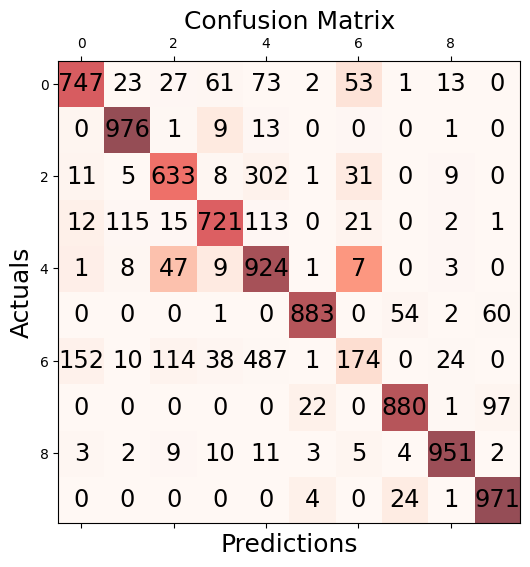

In [117]:
import matplotlib.pyplot as plt
cm_df = pd.DataFrame(confusion_matrix)

fig, ax = plt.subplots(figsize=(6,6))
ax.matshow(cm_df, cmap=plt.cm.Reds, alpha=0.7)
for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        ax.text(x=j, y=i,s=cm_df[i][j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [121]:
# Cols are actual, rows are pred
pred_x_true_df = pd.DataFrame(embedding_organizer)
pred_x_true_df

,0,1,2,3,4,5,6,7,8,9
0,"[[-135.1358, -21.678612, -297.65128, -9.328762...",[],"[[-113.649124, -40.302048, -184.38014, -6.5096...","[[-105.38948, -30.532616, -282.02277, 6.408436...","[[-73.46337, -44.13951, -97.761024, 31.414661,...",[],"[[-138.77669, -2.7990265, -311.66138, -8.81572...",[],"[[-71.21298, -30.380188, -53.941574, 33.26678,...",[]
1,"[[-44.049744, -24.696194, 15.310324, 7.155113,...","[[-47.991714, 46.390354, -117.82573, -115.2926...","[[-65.74298, -40.934845, -74.2828, -68.54166, ...","[[66.92756, 16.953056, -36.140343, -163.06073,...","[[-74.829926, -14.793449, -111.387314, -80.193...",[],"[[-33.534744, 18.885954, -204.358, -122.900635...",[],"[[-12.94807, 85.49689, -105.94153, -148.5646, ...",[]
2,"[[-147.82657, -78.48198, -223.62598, -196.2003...","[[-115.92163, -18.950115, -111.3837, -56.88854...","[[-157.76498, -127.20532, -247.95654, -183.535...","[[-141.22136, -51.66931, -217.15414, -127.9309...","[[-143.70584, -40.41965, -202.11395, -93.55104...",[],"[[-159.25127, -92.521286, -209.2485, -110.0676...",[],"[[-103.95086, -10.226704, -150.93106, -67.4631...",[]
3,"[[-121.2411, 41.00805, -299.2633, -75.53508, -...","[[-94.06746, -18.032196, -189.71773, -127.7690...","[[-36.37009, 3.1658, -113.80261, -58.859474, -...","[[3.7582254, -6.4325676, -154.78534, -151.1094...","[[-36.169205, 7.500538, -138.39061, -113.13396...","[[-64.08211, -36.747017, -114.879, -113.01672,...","[[-128.22711, -9.874432, -297.54462, -70.99711...",[],"[[-33.374588, 6.970318, -120.460365, -66.18331...",[]
4,"[[-200.59705, -54.477215, -265.5298, -189.3255...","[[-82.92369, 49.316025, -197.84204, -96.57701,...","[[-106.52643, -16.624313, -163.18785, -157.811...","[[-124.452286, 45.846138, -258.3841, -99.97502...","[[-142.54279, 12.108791, -261.48264, -135.1014...",[],"[[-75.99635, -15.290134, -166.72296, -138.7355...",[],"[[-150.95877, -36.55697, -130.95096, -88.95712...",[]
5,"[[10.383871, -64.92939, -28.731804, -10.683786...",[],"[[-110.25816, -108.20496, -111.52895, -23.6580...",[],"[[-121.068985, -76.958626, -130.36804, -58.612...","[[-19.271576, -25.936222, 64.837425, -13.5215,...","[[-66.93215, -1.0964117, 3.4210005, -43.8832, ...","[[0.2040348, -36.02063, 10.245804, 56.36144, -...","[[1.2154865, -50.574272, 21.86461, -33.344223,...","[[-34.471252, -134.9415, 13.506149, -37.01809,..."
6,"[[-151.08301, -46.993877, -255.88834, -94.6667...",[],"[[-120.473526, -33.19751, -141.72592, -114.340...","[[-137.54031, -22.62462, -242.50699, -58.35018...","[[-117.681854, -57.613735, -229.04797, -120.62...",[],"[[-121.29675, -74.99295, -175.30371, -74.24495...",[],"[[-101.07919, -64.103935, -182.83768, -75.4149...",[]
7,"[[-13.637449, -65.50758, -51.22492, 34.315964,...",[],[],[],[],"[[-44.693604, -54.219513, 16.171246, -39.75024...",[],"[[-21.165634, -69.362465, 29.889164, 6.452053,...","[[-1.7227783, -30.668158, 19.515501, 10.979862...","[[-17.850788, -83.370026, 7.055439, -37.758926..."
8,"[[-25.737514, 7.0932045, -87.59752, -33.270256...","[[-71.31778, 9.0108795, -63.69726, -37.084637,...","[[-156.57863, -54.625427, -184.5538, -99.36532...","[[-69.12743, 18.03917, -98.82567, -110.90763, ...","[[-101.204, -16.476156, -161.79874, 6.15514, -...","[[-111.527435, 32.245285, -22.109888, -19.3585...","[[-77.65092, 47.417763, -135.56003, 0.4775772,...","[[-58.874943, -0.9476471, 21.536201, -46.94291...","[[-46.826435, -35.760666, -35.77142, -11.51347...","[[-75.63394, -77.532974, -62.327328, -50.88471..."
9,[],[],[],"[[-74.49591, -41.432766, -124.67972, -188.8894...",[],"[[8.7481, -58.832916, -4.5448685, -56.472305, ...",[],"[[10.713638, -101.22564, 21.482584, 41.732475,...","[[-22.342014, -68.86774, -20.672783, -77.22676...","[[13.913822, -54.393673, -15.71793, -35.06788,..."


In [127]:
def avg_emb(x):
    if len(x) > 0:
        return sum(x)/len(x)
    return None

avg_emb_df = pred_x_true_df.applymap(avg_emb)

In [128]:
avg_emb_df

,0,1,2,3,4,5,6,7,8,9
0,"[-112.6164, -22.217028, -247.57188, -4.5772185...",None,"[-125.3023, -49.09757, -206.20966, -27.21388, ...","[-110.182686, -27.375748, -213.2982, -40.65902...","[-73.46337, -44.13951, -97.761024, 31.414661, ...",None,"[-110.83879, -13.289927, -236.81111, -18.13789...",None,"[-118.558235, -34.759117, -127.70835, 14.44614...",None
1,"[-66.37788, 4.74636, -146.89632, -57.93197, -1...","[-31.020548, 42.87038, -123.62816, -117.33216,...","[-50.14461, -28.461813, -85.62085, -92.06783, ...","[-17.905987, 15.506939, -121.13107, -109.71909...","[-63.793545, 18.24833, -165.89316, -92.44417, ...",None,"[-56.37143, 5.911675, -162.1799, -72.857285, -...",None,"[-54.060253, -1.6152115, -135.29758, -86.89151...",None
2,"[-112.91806, -53.100094, -156.38087, -80.05216...","[-115.92163, -18.950115, -111.3837, -56.88854,...","[-127.81978, -55.39848, -186.81131, -128.24777...","[-120.335434, -25.7618, -173.57875, -128.33443...","[-133.27228, -46.508057, -190.43172, -120.3146...",None,"[-118.32028, -45.072174, -160.3834, -111.24792...",None,"[-103.29584, -41.833645, -139.3387, -79.047264...",None
3,"[-78.03558, 11.5906515, -192.02386, -81.63434,...","[-36.416656, 3.1723762, -171.449, -123.306206,...","[-75.06621, -2.8913288, -177.6371, -87.31441, ...","[-59.57921, 2.311582, -194.2034, -122.39236, -...","[-86.03984, -6.6477013, -192.67259, -122.21525...","[-64.08211, -36.747017, -114.879, -113.01672, ...","[-92.52722, 10.073571, -202.1196, -91.69451, -...",None,"[-4.675012, 6.2604456, -102.08404, -82.73896, ...",None
4,"[-99.953094, 6.9380007, -193.26193, -64.50464,...","[-106.85401, 21.184862, -168.44093, -104.00907...","[-127.80276, -17.316914, -203.0792, -137.00035...","[-111.33958, 12.001117, -199.34239, -112.00547...","[-140.01852, -5.046772, -217.53058, -140.36545...",None,"[-121.76783, -12.190778, -195.75412, -120.4998...",None,"[-108.18133, 4.7290263, -176.42438, -95.321144...",None
5,"[-42.519344, -48.04441, -7.1311803, -19.847027...",None,"[-110.25816, -108.20496, -111.52895, -23.65805...",None,"[-121.068985, -76.958626, -130.36804, -58.6127...","[-37.137283, -59.802906, 10.973084, -19.505474...","[-66.93215, -1.0964117, 3.4210005, -43.8832, -...","[-43.55402, -51.104733, 28.460955, -15.555222,...","[-45.05267, -20.950506, -4.73291, -86.926, -89...","[-48.169353, -121.565704, -41.185238, -73.5297..."
6,"[-109.40402, -17.048525, -204.31163, -53.62399...",None,"[-115.83085, -35.149586, -175.01477, -76.69048...","[-108.701675, -11.822154, -175.36398, -68.8175...","[-125.950554, -40.099144, -200.40323, -96.4502...",None,"[-114.47309, -15.086089, -199.61052, -72.34128...",None,"[-112.741554, -22.861597, -179.47362, -67.7213...",None
7,"[-13.637449, -65.50758, -51.22492, 34.315964, ...",None,None,None,None,"[-20.181295, -68.80238, 25.736832, -16.13788, ...",None,"[-16.537622, -73.50058, 28.119259, -3.0838265,...","[-30.538483, -63.349667, 17.49644, 9.523898, -...","[-5.8442483, -101.66581, 15.862331, 4.7337775,..."
8,"[-76.57625, -24.720774, -116.026825, -31.90136...","[-71.31778, 9.0108795, -63.69726, -37.084637, ...","[-101.51017, -13.417515, -145.98975, -87.4175,...","[-36.267433, 7.2195663, -87.94743, -88.49602, ...","[-83.26913, -22.560234, -132.16298, -95.23618,...","[-92.08371, 12.395125, -23.022825, -0.6890249,...","[-96.51105, -18.865942, -140.91269, -41.39075,...","[-58.874943, -0.9476471, 21.536201, -46.942913...","[-48.419556, -6.662386, -68.69488, -60.183132,...","[-75.63394, -77.532974, -62.327328, -50.884716..."
9,None,None,None,"[-74.49591, -41.432766, -124.67972, -188.8894,...",None,"[-13.339591, -94.57229, -19.885622, -48.551407...",None,"[10.783447, -96.43473, 10.973507, -11.311663, ...","[-14.753675, -99.723526, 18.087818, -65.18048,...","[14.478335, -118.01316, -18.152517, -40.640392..."
